# Visual Place Recognition - Proof of Concept Using Spiking Neural Networks

In [26]:
import numpy as np
import torch
import torch.nn as nn
from spikingjelly.activation_based import neuron, encoding
from utils.image_processing import processSingleImage
import matplotlib.pyplot as plt
from utils.plasticity import STDPLearner
import cv2

## Define the network Architecture

In [117]:
class VPR(nn.Module):
    def __init__(self, tau, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layer = nn.Sequential(
            nn.Flatten(start_dim=0, end_dim=-1),
            nn.Linear(28 * 28, 5, bias=False),
            neuron.LIFNode(tau=2., v_threshold=0.6)
        )

    def forward(self, x: torch.Tensor) -> nn.Sequential:
        return self.layer(x)

## Define Learning functions and parameters

In [118]:
def f_pre(x):
    return torch.clamp(x, -1, 1.)

def f_post(x):
    return torch.clamp(x, -1, 1.)

start_epoch = 0
epoch = 200
tau_pre = 5.
tau_post = 5.
lr = 0.001
T = 100
w_min, w_max = -1., 1.

N_out = 5
N_in = 100

## Instance of the Network

In [119]:
net = VPR(tau=2.)
encoder = encoding.PoissonEncoder() # Poison encoder for spike train creation using pixel intensity
learner = STDPLearner(synapse=net.layer[1], tau_pre=tau_pre, tau_post=tau_post,learning_rate=lr, f_post=f_post, f_pre=f_pre)


## Read Image from the Nordland dataset

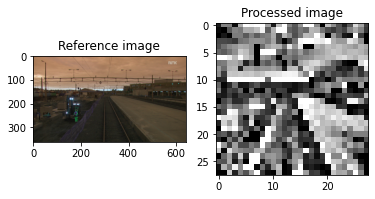

In [120]:
imagePath = "/media/geoffroy/T7/VPRSNN/data/nordland/fall/images-00001.png"
reference_img = cv2.imread(imagePath)
img = processSingleImage(imagePath, 28, 28, 7)

# Plotting Images
plt.figure()
plt.subplot(1,2,1)
plt.title("Reference image")
plt.imshow(reference_img)
plt.subplot(1,2,2)
plt.title("Processed image")
plt.imshow(img, cmap="gray")

## Process image for training

In [121]:
img = torch.from_numpy(img)

In [122]:

# For plotting 
in_spike = []
out_spike = []
trace_pre = []
trace_post = np.zeros((N_out,T))
weights = np.zeros((N_out,T))

trac2 = []

for t in range(T):
    encoded_img = encoder(img)

    # Pre and post spikes, after forward
    in_spike.append(encoded_img[0][0].numpy())
    out_spike.append(net(encoded_img.float()).detach().numpy())

    # Torch Input processing for STDP 
    s_pre = torch.from_numpy(np.expand_dims(net.layer[0](encoded_img.float()), axis=0))
    s_post = torch.from_numpy(np.expand_dims(out_spike[t], axis=0))
    
    # STDP step
    learner.single_step(s_pre, s_post)

    # Plotting 
    trace_pre.append(learner.trace_pre[0][0].numpy())
    trac2.append(learner.trace_post[0][0].numpy())
    for i in range(N_out):
        weights[i][t] = net.layer[1].weight[i][0].detach().numpy()
        trace_post[i][t] = learner.trace_post[0][i].numpy()

## Plotting

In [129]:
t = np.arange(0, T)
out_spike = np.array(out_spike)

neuron1 = out_spike[:,0]
neuron2 = out_spike[:,1]
neuron3 = out_spike[:,2]
neuron4 = out_spike[:,3]
neuron5 = out_spike[:,4]

(100, 5)


Text(0.5, 1.0, 'Post traces of 5 neurons')

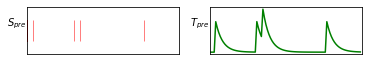

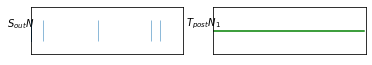

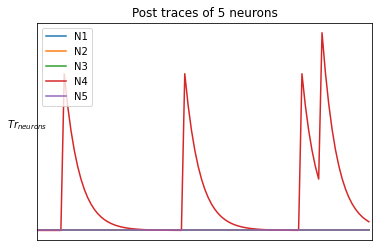

In [137]:
plt.figure()
plt.subplot(4,2,1)
plt.eventplot(t * in_spike, lineoffsets=0, linewidths=0.5, colors='r')
plt.yticks([])
plt.ylabel('$S_{pre}$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)

plt.subplot(4,2,2)
plt.plot(t, trace_pre, c="green")
plt.yticks([])
plt.ylabel('$T_{pre}$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)

plt.figure()
plt.subplot(4,2,3)
for i in range(N_out):
    plt.eventplot(t * out_spike[:,i], lineoffsets=0, linewidths=0.5, label="N"+str(i+1))
plt.yticks([])
plt.ylabel('$S_{out} N$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)

plt.subplot(4,2,4)
plt.plot(t, trac2, c="green")
plt.yticks([])
plt.ylabel('$T_{post} N_1$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)




plt.figure()
plt.plot(t, trace_post[0], label="N1")
plt.plot(t, trace_post[1], label="N2")
plt.plot(t, trace_post[2], label="N3")
plt.plot(t, trace_post[3], label="N4")
plt.plot(t, trace_post[4], label="N5")
plt.yticks([])
plt.ylabel('$Tr_{neurons}$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)
plt.legend()
plt.title("Post traces of 5 neurons")